In [20]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import csv

In [21]:
# Load training and testing data
training_data = pd.read_csv("train.csv")
testing_data = pd.read_csv("test.csv")

# Store the unique identifier of each passenger in a separate dataframe for later use
trainingIndex = pd.DataFrame()
trainingIndex["PassengerId"] = training_data["PassengerId"]

testingIndex = pd.DataFrame()
testingIndex["PassengerId"] = testing_data["PassengerId"]

# Extract target values
trainingTargets = pd.DataFrame()
trainingTargets["Survived"] = training_data["Survived"]

# Remove columns containing information that is not strictly related to a passenger's survival
columns_to_drop = ["PassengerId", "Name", "Ticket", "Fare", "Embarked", "Survived"]
training_data = training_data.drop(columns=columns_to_drop, axis=1)
testing_data = testing_data.drop(columns=list(set(columns_to_drop) - {"Survived"}), axis=1)

In [22]:
# Find non numerical columns
columns_to_encode = training_data.select_dtypes(exclude=['number']).columns

# One hot encode the 'Sex' column
training_data = pd.get_dummies(training_data, columns=['Sex'])
testing_data = pd.get_dummies(testing_data, columns=['Sex'])

In [23]:
# Convert cabin numbers to simple cabin classes. E.g C58 --> C, A12 --> A
def extract_first_char(value):
    if pd.notna(value): 
        return value[0] 
    else:
        return np.nan

training_data['Cabin'] = training_data['Cabin'].apply(lambda x: extract_first_char(x))
testing_data['Cabin'] = testing_data['Cabin'].apply(lambda x: extract_first_char(x))

In [24]:
# Columns to impute
mean_imputation_columns = ["Age"]
most_frequent_imputation_columns = ["Cabin"]

# Instantiate the imputers
mean_imputer = SimpleImputer(strategy='mean')
most_frequent_imputer = SimpleImputer(strategy='most_frequent')

# Fit the imputer on the selected columns
mean_imputer.fit(training_data[mean_imputation_columns])
most_frequent_imputer.fit(training_data[most_frequent_imputation_columns])

# Transform the selected columns
training_data[mean_imputation_columns] = mean_imputer.transform(training_data[mean_imputation_columns])
training_data[most_frequent_imputation_columns] = most_frequent_imputer.transform(training_data[most_frequent_imputation_columns])

testing_data[mean_imputation_columns] = mean_imputer.transform(testing_data[mean_imputation_columns])
testing_data[most_frequent_imputation_columns] = most_frequent_imputer.transform(testing_data[most_frequent_imputation_columns])

# One hot encode the 'Cabin' column
training_data = pd.get_dummies(training_data, columns=['Cabin'])
testing_data = pd.get_dummies(testing_data, columns=['Cabin'])

In [25]:
# Scale age values to the 0-1 value range
scaler = MinMaxScaler()
training_data["Age"] = scaler.fit_transform(training_data[["Age"]])
testing_data["Age"] = scaler.transform(testing_data[["Age"]])

In [26]:
# Create and compile models to be used
model = Sequential([
    Dense(8, activation='relu', input_shape=(training_data.shape[1],)),
    Dense(4, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model2 = Sequential([
    Dense(32, activation='relu', input_shape=(training_data.shape[1],)),
    Dense(16, activation='relu'),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')
])
model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model3 = Sequential([
    Dense(64, activation='relu', input_shape=(training_data.shape[1],)),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])
model3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

/Users/ioannisdrossas/Desktop/Titanic/venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3469 - loss: 0.8574 - val_accuracy: 0.2222 - val_loss: 0.7968
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3232 - loss: 0.7689 - val_accuracy: 0.2889 - val_loss: 0.7253
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3079 - loss: 0.7101 - val_accuracy: 0.5667 - val_loss: 0.6964
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step - accuracy: 0.6412 - loss: 0.6848 - val_accuracy: 0.6000 - val_loss: 0.6917
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 874us/step - accuracy: 0.6618 - loss: 0.6809 - val_accuracy: 0.6111 - val_loss: 0.6891
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step - accuracy: 0.6597 - loss: 0.6809 - val_accuracy: 0.6222 - val_loss: 0.6866
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step - accuracy: 0.6739 - loss: 0.6783 - val_accuracy: 0.6222 - val_loss: 0.6843
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step - accuracy: 0.6864 - loss: 0.6739 - val_accuracy: 

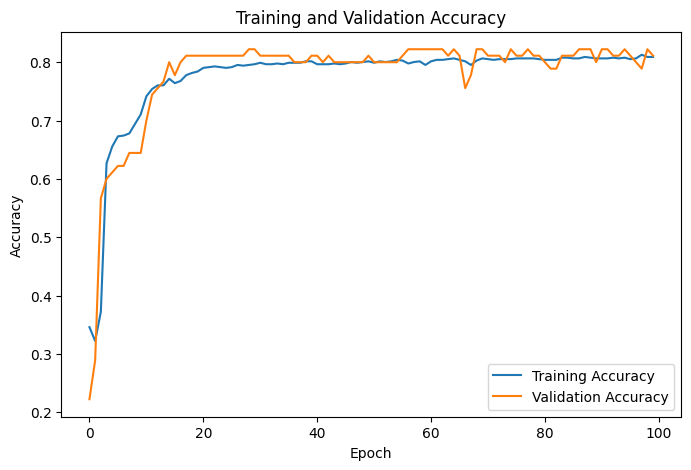

In [27]:
# Train the models
training_data, validation_data, training_targets, validation_targets = train_test_split(training_data, trainingTargets, test_size=0.1, random_state=42)
history = model.fit(training_data, training_targets, epochs=100, batch_size=32, validation_data=(validation_data, validation_targets),  verbose=1)
history2 = model2.fit(training_data, training_targets, epochs=35, batch_size=32, validation_data=(validation_data, validation_targets),  verbose=1)
history3 = model3.fit(training_data, training_targets, epochs=20, batch_size=32, validation_data=(validation_data, validation_targets),  verbose=1)

# Plot training loss and accuracy
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [28]:
testing_data["Cabin_T"] = 0

predictions = model.predict(testing_data)
predictions2 = model2.predict(testing_data)
predictions3 = model3.predict(testing_data)

binary_predictions = (predictions > 0.5).astype(int)
binary_predictions2 = (predictions2 > 0.5).astype(int)
binary_predictions3 = (predictions3 > 0.5).astype(int)

final_predictions = []
for i in range(len(predictions)):
    if binary_predictions[i] + binary_predictions2[i] + binary_predictions3[i] > 1:
        final_predictions.append(1)
    else:
        final_predictions.append(0)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [29]:
import csv

filename = 'my_predictions.csv'

predictions_list = list(final_predictions)
index_list = testingIndex['PassengerId'].tolist()

with open(filename, 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    
    # Write header row
    csvwriter.writerow(["PassengerId", "Survived"])
    
    # Write data rows
    for index in range(418):
        passenger_id = index_list[index]
        prediction = predictions_list[index]
        csvwriter.writerow([passenger_id, prediction])
